In [57]:
import pandas as pd
import dask.dataframe as dd
import io
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")

In [2]:
file_name = "2020_Business_Academic_QCQ.txt"
city = 'HILO'
state = 'HI'

def create_df(file_name, city, state):
    lines_left = True
    with open(file_name, encoding='ISO-8859-1') as f:
        header = f.readline()
        whole_df = None
        while True:
            lines = [header]
            for i in range(5000):
                line = f.readline()
                if not line:
                    lines_left = False
                    break
                lines.append(line)
            df = pd.read_csv(io.StringIO("\n".join(lines)))
            df_filtered = df[(df['City'] == city) & (df['State'] == state)]
            if len(df_filtered) > 0:
                whole_df = df_filtered if whole_df is None else pd.concat([whole_df, df_filtered])
            if not lines_left:
                return whole_df
                


In [6]:
df = create_df(file_name, city, state)

In [58]:
hilo_foot_traffic = pd.read_parquet('hilo_full_patterns.parquet')
hilo_foot_traffic['year'] = hilo_foot_traffic['date_range_start'].str[0:4].astype("Int64")
hilo_foot_traffic_2020 = hilo_foot_traffic[hilo_foot_traffic['year'] == 2020]
hilo_foot_traffic_2020['location_name'] = [x.upper() for x in list(hilo_foot_traffic_2020['location_name'])]
hilo_foot_traffic_2020['street_address'] = [x.upper() for x in list(hilo_foot_traffic_2020['street_address'])]

In [59]:
hilo_foot_traffic_2020_com = hilo_foot_traffic_2020.groupby(['location_name', 'latitude', 'longitude', 'street_address']).agg({'raw_visit_counts': 'sum'}).reset_index()

In [60]:
business_sales = df[['Company', 'Address Line 1', 'Latitude', 'Longitude', 'Sales Volume (9) - Location']]

In [61]:
merged_df = pd.merge(hilo_foot_traffic_2020_com, business_sales, 
                     left_on=['street_address'], 
                     right_on=['Address Line 1'], 
                     how='left')

merged_df = merged_df.dropna()

In [62]:
min_lat = min(list(merged_df['latitude']))
min_long = min(list(merged_df['longitude']))
max_lat = max(list(merged_df['latitude']))
max_long = max(list(merged_df['longitude']))

In [63]:
import math

# Set the number of desired regions
x = 11

# Find factors of x
factors = [(i, x//i) for i in range(1, int(math.sqrt(x)) + 1) if x % i == 0]

# Choose the factors that are closest to each other
factor1, factor2 = min(factors, key=lambda f: abs(f[0] - f[1]))

# Calculate latitude and longitude ranges
lat_range = max_lat - min_lat
long_range = max_long - min_long

# Calculate latitude and longitude step sizes for x regions
lat_step = lat_range / factor1
long_step = long_range / factor2

# Define a function to assign region based on latitude and longitude
def assign_region(row):
    lat_region = int((row['latitude'] - min_lat) / lat_step) + 1
    long_region = int((row['longitude'] - min_long) / long_step) + 1
    return (lat_region - 1) * factor2 + long_region

# Create a new column 'geographic_region' based on latitude and longitude
merged_df['geographic_region'] = merged_df.apply(assign_region, axis=1)


In [64]:
region_aggregate_df = merged_df.groupby('geographic_region').agg({
    'Sales Volume (9) - Location': 'sum',
    'raw_visit_counts': 'sum'
}).reset_index()

In [65]:
slope, intercept, r_value, p_value, std_err = linregress(region_aggregate_df['Sales Volume (9) - Location'], region_aggregate_df['raw_visit_counts'])

In [66]:
r_value

0.9637863087259542

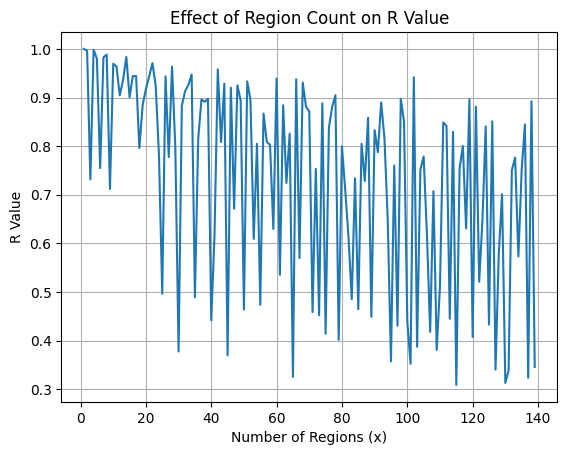

In [67]:
import math
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Define a function to calculate r_value for a given x
def calculate_r_value(x):
    # Find factors of x
    factors = [(i, x // i) for i in range(1, int(math.sqrt(x)) + 1) if x % i == 0]
    # Choose the factors that are closest to each other
    factor1, factor2 = min(factors, key=lambda f: abs(f[0] - f[1]))
    # Calculate latitude and longitude step sizes for x regions
    lat_step = lat_range / factor1
    long_step = long_range / factor2

    # Define a function to assign region based on latitude and longitude
    def assign_region(row):
        lat_region = int((row['latitude'] - min_lat) / lat_step) + 1
        long_region = int((row['longitude'] - min_long) / long_step) + 1
        return (lat_region - 1) * factor2 + long_region

    # Create a new column 'geographic_region' based on latitude and longitude
    merged_df['geographic_region'] = merged_df.apply(assign_region, axis=1)

    # Group by geographic region and aggregate data
    region_aggregate_df = merged_df.groupby('geographic_region').agg({
        'Sales Volume (9) - Location': 'sum',
        'raw_visit_counts': 'sum'
    }).reset_index()

    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(region_aggregate_df['Sales Volume (9) - Location'], region_aggregate_df['raw_visit_counts'])
    return r_value

# Initialize lists to store x values and r_values
x_values = list(range(1, 140))
r_values = []

# Calculate r_value for each x
for x in x_values:
    r_value = calculate_r_value(x)
    r_values.append(r_value)

# Plot the results
plt.plot(x_values, r_values)
plt.xlabel('Number of Regions (x)')
plt.ylabel('R Value')
plt.title('Effect of Region Count on R Value')
plt.grid(True)
plt.show()


In [68]:
import math
import pandas as pd
from scipy.stats import linregress

# Set the number of desired regions
x = 101

# Find factors of x
factors = [(i, x // i) for i in range(1, int(math.sqrt(x)) + 1) if x % i == 0]

# Choose the factors that are closest to each other
factor1, factor2 = min(factors, key=lambda f: abs(f[0] - f[1]))

# Calculate latitude and longitude ranges
lat_range = max_lat - min_lat
long_range = max_long - min_long

# Calculate latitude and longitude step sizes for x regions
lat_step = lat_range / factor1
long_step = long_range / factor2

# Define a function to assign region based on latitude and longitude
def assign_region(row):
    lat_region = int((row['latitude'] - min_lat) / lat_step) + 1
    long_region = int((row['longitude'] - min_long) / long_step) + 1
    return (lat_region - 1) * factor2 + long_region

# Create a new column 'geographic_region' based on latitude and longitude
merged_df['geographic_region'] = merged_df.apply(assign_region, axis=1)

# Group by geographic region and find top sales in each region
top_sales_in_regions = merged_df.groupby('geographic_region').apply(lambda group: group.nlargest(1, 'Sales Volume (9) - Location'))

# Print the street addresses of the businesses with top sales in each region
for index, row in top_sales_in_regions.iterrows():
    print(f"Region {index}: {row['street_address']}")


Region (1, 792): 1915 KAUMANA DR
Region (5, 928): 100 KULANIAPIA DR
Region (13, 1222): 99 KOKEA ST
Region (21, 648): 120 HOAKA RD
Region (22, 817): 1292 WAIANUENUE AVE
Region (23, 464): 1333 WAIANUENUE AVE
Region (24, 675): 1190 WAIANUENUE AVE
Region (26, 958): 140 RAINBOW DR
Region (27, 577): 370 KAUMANA DR
Region (28, 236): 47 RAINBOW DR
Region (29, 1079): 840 KUPULAU RD
Region (30, 741): 1011 WAIANUENUE AVE
Region (31, 887): 28 PUUHINA ST
Region (32, 6): 83 KAUMANA DR
Region (35, 403): 1141 W KAWAILANI ST
Region (36, 341): 36 KOMOHANA ST
Region (37, 272): 82 PUUHONU PL
Region (38, 508): 131 PUUHONU WAY
Region (39, 803): 351 OHUKEA ST
Region (40, 960): 944 W KAWAILANI ST
Region (41, 125): 41 LAIMANA ST
Region (42, 188): 445 WAIANUENUE AVE
Region (43, 1024): 208 WAINAKU ST
Region (44, 899): 317 WAIANUENUE AVE
Region (45, 1185): 224 HAILI ST
Region (46, 401): 250 KINOOLE ST
Region (47, 1543): 340 KINOOLE ST
Region (48, 909): 321 KEAWE ST
Region (49, 583): 632 KINOOLE ST
Region (50, 578

In [69]:
def merge(business_df, foot_df, year):
    foot_df['year'] = foot_df['date_range_start'].str[0:4].astype("Int64")
    foot_df_year = foot_df[foot_df['year'] == year]
    foot_df_year['location_name'] = [x.upper() for x in list(foot_df_year['location_name'])]
    foot_df_year['street_address'] = [x.upper() for x in list(foot_df_year['street_address'])]
    foot_df_year_com = foot_df_year.groupby(['location_name', 'latitude', 'longitude', 'street_address']).agg({'raw_visit_counts': 'sum'}).reset_index()
    business_sales = business_df[['Company', 'Address Line 1', 'Latitude', 'Longitude', 'Sales Volume (9) - Location']]
    merged_df = pd.merge(foot_df_year_com, business_sales, 
                         left_on=['street_address'], 
                         right_on=['Address Line 1'], 
                         how='left')

    merged_df = merged_df.dropna()
    
    return merged_df

In [70]:
def r_plot(merged_df):
    # Initialize lists to store x values and r_values
    x_values = list(range(1, 140))
    r_values = []

    # Calculate r_value for each x
    for x in x_values:
        r_value = calculate_r_value(x, merged_df)
        r_values.append(r_value)

    # Plot the results
    plt.plot(x_values, r_values)
    plt.xlabel('Number of Regions (x)')
    plt.ylabel('R Value')
    plt.title('Effect of Region Count on R Value')
    plt.grid(True)
    plt.show()


In [73]:
from scipy.spatial.distance import cdist

def find_top_businesses(business_df, foot_df, year, radius_km=1.0):
    # Filter foot traffic data for the specified year
    foot_df['year'] = foot_df['date_range_start'].str[0:4].astype("Int64")
    foot_df_year = foot_df[foot_df['year'] == year]
    foot_df_year['location_name'] = [x.upper() for x in list(foot_df_year['location_name'])]
    foot_df_year['street_address'] = [x.upper() for x in list(foot_df_year['street_address'])]

    # Group foot traffic data by business location and sum up foot traffic counts
    foot_traffic_by_business = foot_df_year.groupby(['location_name', 'latitude', 'longitude', 'street_address'])['raw_visit_counts'].sum().reset_index()

    top_businesses = []

    for _, business_row in business_df.iterrows():
        # Extract latitude and longitude of the current business
        business_lat = business_row['Latitude']
        business_long = business_row['Longitude']

        # Calculate the distance between the business and foot traffic locations
        distances = cdist([(business_lat, business_long)], foot_traffic_by_business[['latitude', 'longitude']], 
                          metric='euclidean').flatten()

        # Filter foot traffic locations within the specified radius
        foot_traffic_within_radius = foot_traffic_by_business[distances <= radius_km]

        # Calculate total foot traffic in the area surrounding the business
        total_foot_traffic = foot_traffic_within_radius['raw_visit_counts'].sum()

        # Append the total foot traffic along with business information to the list of top businesses
        top_businesses.append({
            'Company': business_row['Company'],
            'Address Line 1': business_row['Address Line 1'],
            'Latitude': business_lat,
            'Longitude': business_long,
            'Total Foot Traffic': total_foot_traffic
        })

    # Convert the list of top businesses to a DataFrame
    top_businesses_df = pd.DataFrame(top_businesses)

    # Sort the DataFrame by total foot traffic in descending order
    top_businesses_df = top_businesses_df.sort_values(by='Total Foot Traffic', ascending=False)
    
    return top_businesses_df

In [79]:
find_top_businesses(df, hilo_foot_traffic, 2020, 0.01)['Total Foot Traffic'].unique()

array([6.36163e+05, 6.34873e+05, 6.32891e+05, 6.32386e+05, 6.31899e+05,
       6.30700e+05, 6.30460e+05, 6.30170e+05, 6.29884e+05, 6.29444e+05,
       6.28334e+05, 6.27951e+05, 6.27753e+05, 6.27638e+05, 6.27444e+05,
       6.27194e+05, 6.26060e+05, 6.23753e+05, 6.23117e+05, 6.22454e+05,
       6.22201e+05, 6.20812e+05, 6.20440e+05, 6.16495e+05, 6.12139e+05,
       6.11267e+05, 6.08585e+05, 6.06308e+05, 6.06213e+05, 6.05379e+05,
       6.05336e+05, 6.04168e+05, 6.03937e+05, 6.03584e+05, 6.02548e+05,
       6.02434e+05, 6.01797e+05, 6.01749e+05, 6.01255e+05, 6.00945e+05,
       6.00927e+05, 6.00586e+05, 6.00160e+05, 6.00054e+05, 6.00038e+05,
       5.99676e+05, 5.98778e+05, 5.96943e+05, 5.96254e+05, 5.95532e+05,
       5.95371e+05, 5.94785e+05, 5.92338e+05, 5.92218e+05, 5.92128e+05,
       5.90403e+05, 5.88972e+05, 5.87314e+05, 5.86593e+05, 5.85832e+05,
       5.84331e+05, 5.83419e+05, 5.82907e+05, 5.80776e+05, 5.79959e+05,
       5.76671e+05, 5.75832e+05, 5.75030e+05, 5.74736e+05, 5.736

In [102]:
import pandas as pd
from scipy.spatial.distance import cdist

def find_top_unique_business_addresses(business_df, foot_df, year, min_unique_businesses=100, max_radius_km=1.0, radius_step=0.1):
    # Filter foot traffic data for the specified year
    foot_df['year'] = foot_df['date_range_start'].str[0:4].astype("Int64")
    foot_df_year = foot_df[foot_df['year'] == year]
    foot_df_year['location_name'] = [x.upper() for x in list(foot_df_year['location_name'])]
    foot_df_year['street_address'] = [x.upper() for x in list(foot_df_year['street_address'])]

    # Group foot traffic data by business location and sum up foot traffic counts
    foot_traffic_by_business = foot_df_year.groupby(['location_name', 'latitude', 'longitude', 'street_address'])['raw_visit_counts'].sum().reset_index()

    unique_businesses = set()
    radius_km = max_radius_km  # Starting radius

    while radius_km > 0:
        top_businesses = []

        for _, business_row in business_df.iterrows():
            # Extract latitude and longitude of the current business
            business_lat = business_row['Latitude']
            business_long = business_row['Longitude']

            # Calculate the distance between the business and foot traffic locations
            distances = cdist([(business_lat, business_long)], foot_traffic_by_business[['latitude', 'longitude']], 
                              metric='euclidean').flatten()

            # Filter foot traffic locations within the specified radius
            foot_traffic_within_radius = foot_traffic_by_business[distances <= radius_km]

            # Calculate total foot traffic in the area surrounding the business
            total_foot_traffic = foot_traffic_within_radius['raw_visit_counts'].sum()

            # Append the total foot traffic along with business information to the list of top businesses
            top_businesses.append({
                'Company': business_row['Company'],
                'Address Line 1': business_row['Address Line 1'],
                'Latitude': business_lat,
                'Longitude': business_long,
                'Total Foot Traffic': total_foot_traffic
            })

        # Convert the list of top businesses to a DataFrame
        top_businesses_df = pd.DataFrame(top_businesses)

        # Sort the DataFrame by total foot traffic in descending order
        top_businesses_df = top_businesses_df.sort_values(by='Total Foot Traffic', ascending=False)

        # Add unique businesses to the set
        unique_businesses.update(top_businesses_df.drop_duplicates(subset='Total Foot Traffic')['Address Line 1'])

        # Check if enough unique businesses are found
        if len(unique_businesses) >= min_unique_businesses:
            break

        # Increase radius for the next iteration
        radius_km -= radius_step

    # Return the street addresses of the top unique businesses
    return top_businesses_df[top_businesses_df['Address Line 1'].isin(unique_businesses)]['Address Line 1'].tolist()

In [103]:
find_top_unique_business_addresses(df, hilo_foot_traffic, 2020, min_unique_businesses=20, max_radius_km=0.2, radius_step=0.05)

['1091 KAHOLO ST',
 '2159 KINOOLE ST # B',
 '2070 KILAUEA AVE',
 '2070 KILAUEA AVE',
 '2070 KILAUEA AVE',
 '2070 KILAUEA AVE',
 '2100 KANOELEHUA AVE # 404',
 '777 KILAUEA AVE',
 '777 KILAUEA AVE',
 '777 KILAUEA AVE',
 '777 KILAUEA AVE',
 '777 KILAUEA AVE',
 '777 KILAUEA AVE',
 '777 KILAUEA AVE',
 '777 KILAUEA AVE',
 '777 KILAUEA AVE',
 '777 KILAUEA AVE',
 '777 KILAUEA AVE',
 '777 KILAUEA AVE',
 '777 KILAUEA AVE',
 '777 KILAUEA AVE',
 '777 KILAUEA AVE',
 '777 KILAUEA AVE',
 '777 KILAUEA AVE',
 '777 KILAUEA AVE',
 '80 PAUAHI ST # 101',
 '75 AUPUNI ST',
 '75 AUPUNI ST',
 '75 AUPUNI ST',
 '75 AUPUNI ST',
 '75 AUPUNI ST',
 '75 AUPUNI ST',
 '75 AUPUNI ST',
 '75 AUPUNI ST',
 '75 AUPUNI ST',
 '75 AUPUNI ST',
 '75 AUPUNI ST',
 '75 AUPUNI ST',
 '80 PAUAHI ST # 101',
 '75 AUPUNI ST',
 '80 PAUAHI ST # 101',
 '75 AUPUNI ST',
 '2420 KILAUEA AVE',
 '50 E PUAINAKO ST',
 '50 E PUAINAKO ST',
 '50 E PUAINAKO ST',
 '50 E PUAINAKO ST',
 '50 E PUAINAKO ST',
 '50 E PUAINAKO ST',
 '50 E PUAINAKO ST',
 '88 AWA